# this notebook parse patch data
# TODO: meet with Venu to confirm the changes I made



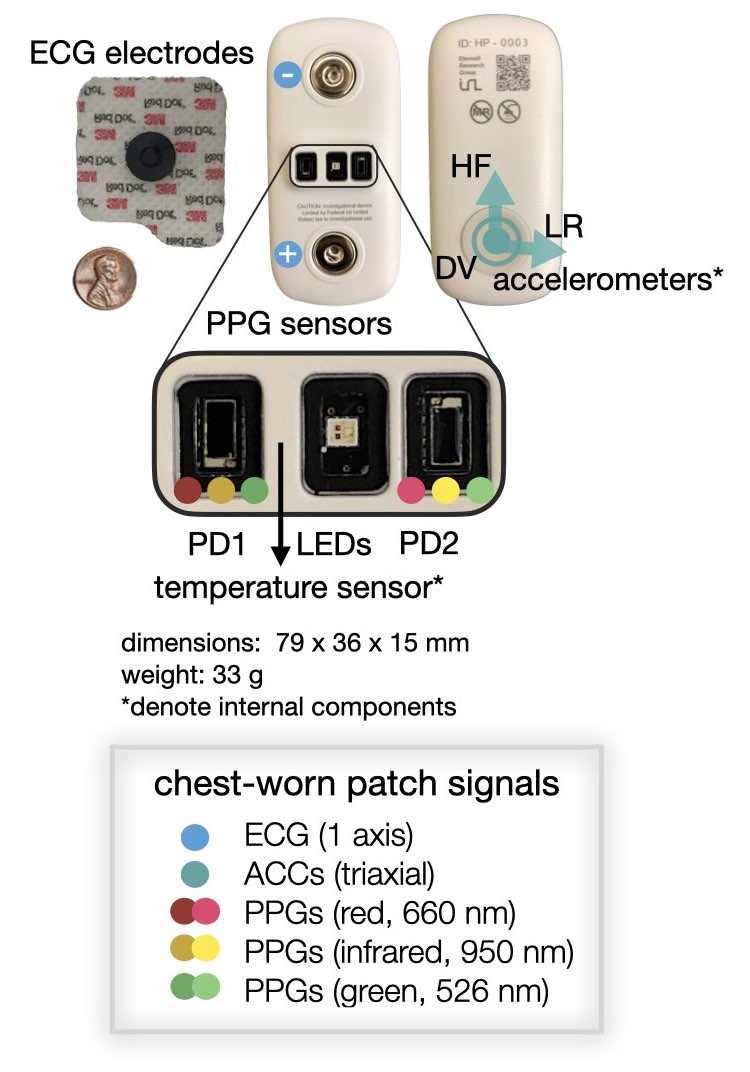





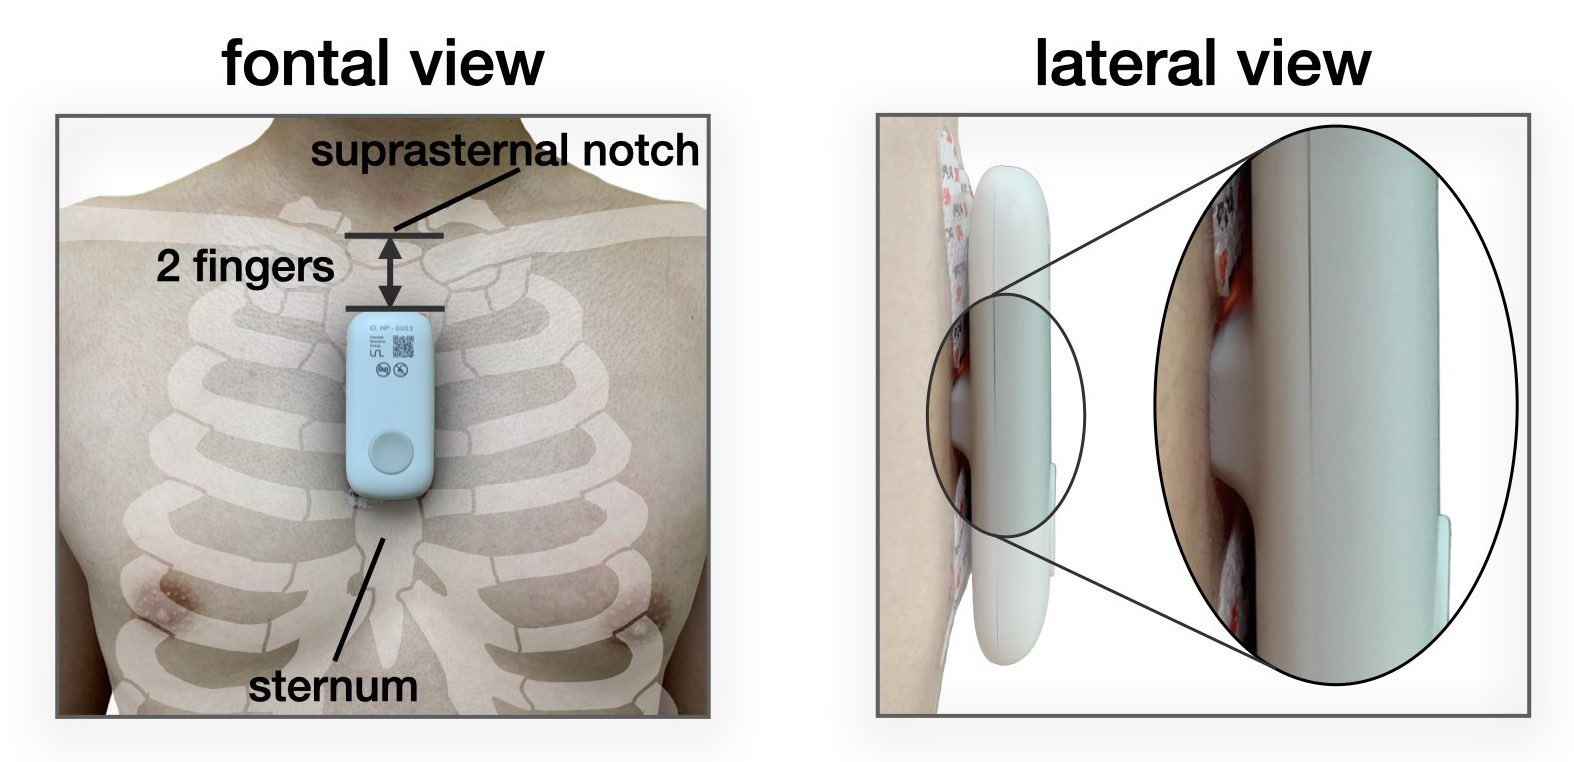

In [6]:
import numpy as np
import argparse

import os
import math
from math import sin

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from plotting_tools import *
from stage1_patch import *
from PatchParser import *


from importlib import reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--log_wandb', metavar='log_wandb', help='log_wandb',
                    default=True)
parser.add_argument('--ignore_past', metavar='ignore_past', help='ignore_past',
                    default=False)


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/raw/', 
                          '--output_folder', '../../data/stage1/',
                         ])
# args = parser.parse_args()
print(args)

Namespace(ignore_past=False, input_folder='../../data/raw/', log_wandb=True, output_folder='../../data/stage1/')


In [8]:

inputdir = args.input_folder
outputdir = args.output_folder

log_wandb = args.log_wandb # boolean
ignore_past = args.ignore_past # boolean
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

In [9]:
# fileName = inputdir+'sub002_111821/HP-0224_20211118_005947.bin'
fileName = inputdir+'sub002_111821/HP-0224_20211118_151651.bin'
# fileName = inputdir+'HP-0202_20211210_171841.bin'
fileName

'../../data/raw/sub002_111821/HP-0224_20211118_151651.bin'

In [10]:
file = open(fileName, mode='rb')
fileContent = file.read()
raw_dict = parse(fileContent, header = True, print_updates = False, isConvUnits = True)

# 1. compute sensitivity (responsivity)

## step 1. extract datapoints from the plots (stored in X and Y in the later cell)

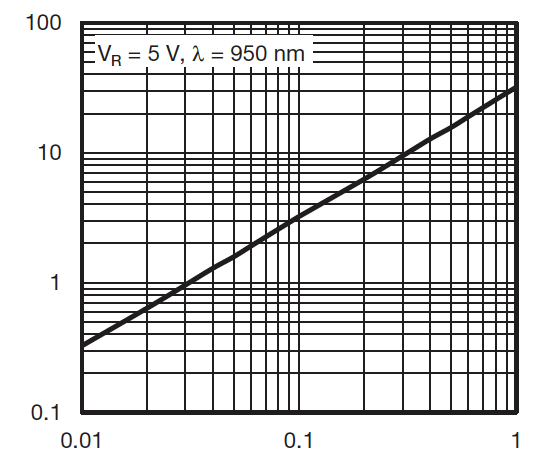# 

</br>

**source: VEMD8080 dataset Fig3**

## In this log-log plot, log I and log E appear to be in a linear relationship
## log (I) = m x log (E) + b
## find $m^{*}, b^{*}$

In [139]:
import numpy as np
from sklearn.linear_model import LinearRegression

# these datapoints are extracted from the PPG sensor datasheet
X = np.log(np.array([0.01, 0.04, 0.1, 0.5, 1]))[:,None]
Y = np.log(np.array([0.33, 1.29, 3.22, 15.72, 31.72]))
reg = LinearRegression().fit(X, Y)
print(reg.coef_[0], reg.intercept_)

0.9907316466170132 3.449347778584159


In [140]:
np.exp(reg.intercept_)

31.479853776840027

## since the power is close to 1 (m), the linear relationship also holds in linear space because....
## $m^{*}≈1, b^{*}≈3.45$

## so log (I) ≈ 1 x log (E) + 3.45
## take exponential
## I ≈  e^(3.45) * E


## I (in μA) ≈ 31.48 * E (in mW/$cm^{2}$)

## a line is considered to have a unity power when m is 1. 

## R = I/P = [ 1 uA x (10^-6 A/uA) ]  / [ 1 (mW/cm2) x (10^-3 W/mW) x (0.01 cm2/mm2) x 4.55mm2 ]
## R = 7.06e-4 (A/W)

where P = E * area (area can be found in the datasheet)

In [141]:
import math

R_950 = 1 * 1e-6 / (31.48 * 1 * 1e-3 * 1e-2 * 4.55)
R_950

0.0006981582585140399

# 1. parse data (bin->npy)

> ## for all of the ppg signals multiply their raw signals by 61e-6 (this will convert them from bits into uA), </br>
> ## for the red and IR signals subtract 8 uA from the signals after the conversion to account for the PD bias of 8 uA. Please make these changes to all the readW4 python files so its there the moment we are converting the binary files

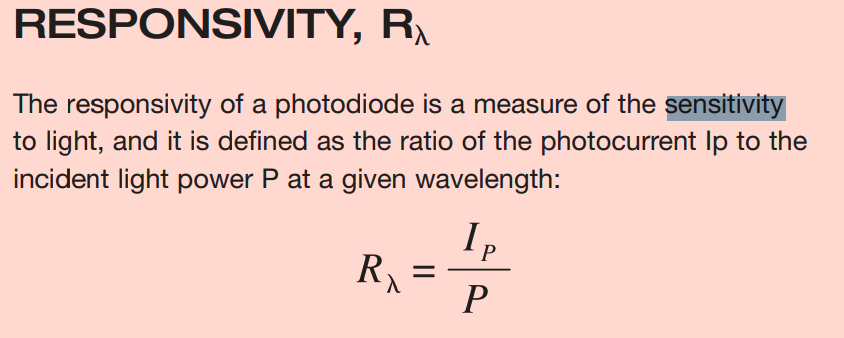

# R_lamda is extracted from the image in VEMD8080 datasheet 
I = current, P = power

P = I/R

In [142]:
R_lamda_relative = {
    'green': 0.622, # 526nm
    'red': 0.828, # 660nm
    'infrared': 0.825, # 950 nm
}

R_lamda = {} # the unit is A/W

for key in R_lamda_relative:
    R_lamda[key] = R_lamda_relative[key] * R_950 / R_lamda_relative['infrared']

R_lamda

{'green': 0.000526369014297858,
 'red': 0.0007006970158177274,
 'infrared': 0.0006981582585140399}

In [143]:
for key in R_lamda_relative:
    print(R_lamda_relative[key] / R_lamda[key]) 

1181.6805
1181.6805
1181.6805000000002


# check 1: how to convert PPG properly using c_PDbias

In [153]:
def PPGunit_conversion(ppg, firmware_id, wavelength ):
    """
    PPGunit_conversion converts ppg (of a wavelength) data exported from the patch to the right unit

    ppg: the ppg data from the patch
    firmware_id: different firmwares have different PD bias (in the SpO2 study, we use firmware_id=1)

    wavelength: wavelength of the ppg
    return: ppg_uW (ppg data in MicroWatt)
    """ 
    if firmware_id == 0:
        c_PDbias = 8 # uA
    else:
        c_PDbias = 0 # uA
    
    c_bits2uA = 61e-6 # uA/bits
    
    ppg_uA = ((ppg*c_bits2uA)-c_PDbias) # uA
#     ppg_uW = ppg_uA / R_lamda_relative[wavelength] #uW
    ppg_uW = ppg_uA / R_lamda[wavelength] # uW = uA / (A/W)
    return ppg_uW



# def PPGunit_conversion(ppg, wavelength, c_PDbias):
#     """
#     PPGunit_conversion converts ppg (of a wavelength) data exported from the patch to the right unit

#     ppg: the ppg data from the patch
#     wavelength: wavelength of the ppg
#     c_PDbias: the biasing current recorded by the patch device (to improve signal quality)
#     return: ppg_uW (ppg data in MicroWatt)
#     """ 
    
    
#     # return ECG values in uW
#     # editted 11/17. Don't need to adjust for bias based on firmware_id anymore
# #     if firmware_id == 0:
# #         c_PDbias = 8 # uA
# #     else:
# #         c_PDbias = 0 # uA
    
#     # TODO: ask venu how to set this parameter
# #     c_PDbias = 0 # uA

#     c_bits2uA = 61e-6 # uA/bits
    
# #     ppg_uA = ((ppg*c_bits2uA)-c_PDbias) # uA
#     # TODO: ask venu if the unit of the current is in nA
#     ppg_uA = ppg*c_bits2uA-c_PDbias/1000 # (b/c nA = 1e-3 uA)

# #     ppg_uW = ppg_uA / R_lamda_relative[wavelength] #uW
#     ppg_uW = ppg_uA / R_lamda[wavelength] # uW = uA / (A/W)
#     return ppg_uW


# def PPGunit_conversion(ppg, firmware_id, wavelength):
    
#     if firmware_id == 0:
#         c_PDbias = 8 # uA
#     else:
#         c_PDbias = 0 # uA
    
#     c_bits2uA = 61e-6 # uA/bits
    
#     ppg_uA = ((ppg*c_bits2uA)-c_PDbias) # uA
# #     ppg_uW = ppg_uA / R_lamda_relative[wavelength] #uW
#     ppg_uW = ppg_uA / R_lamda[wavelength] # uW = uA / (A/W)
#     return ppg_uW



In [145]:
def ECGunit_conversion(ecg):
    # return ECG values in V
    # Data formatt pg 28 ads1291
    # Figure the conversion factor for counts to volts
    ecg_gain = 8
    ecg_vRef = 2.42
#     ecg_volts_per_bit = (ecg_vRef/ecg_gain)/(2^23-1) # (V/bit)
    ecg_volts_per_bit = (ecg_vRef/ecg_gain)/(2**23-1) # (V/bit)
    # Convert to volts
    ecg = (ecg * ecg_volts_per_bit) # V
    return ecg

# check 2: how to convert ACC properly

In [146]:
def ACCunit_conversion(acc):
    # editted 12/10/2021
    # the acc data is LSB
    # we just need to convert it to g using 256000 LSB/g
    acc = acc /  256000 # g
    return acc


In [147]:
np.log(32767)/np.log(2)
2**15

32768

In [330]:
import numpy as np
import sys
import time
import struct
import datetime

def bytetoint(byte):
    if byte > 127:
        return byte - 256
    else:
        return byte
    
def bytestoint(byte):
    data = byte[0]*256 + byte[1]
    if data > 32767: # 32767 = 15 bit
        return data - 65536 # 65536 = 16 bit
    else:
        return data

def parse(fileName, header = True, print_updates = False):
    
    file = open(fileName, mode='rb')
    fileContent = file.read()
#     data = fileContent[512:]
    data = fileContent

    time1 = time.time()

    AST_SR = 16384/(2*2)
       
    ts = int.from_bytes(data[50:58], "big")
    dt = datetime.datetime(1601, 1, 1, 0, 0, 0) + datetime.timedelta(seconds = ts/1e7)
    dt.ctime()

    if(header and not(dt < datetime.datetime.utcnow() < dt + datetime.timedelta(hours = 3*365*24))):
        data = data[512:]
       
        ts = int.from_bytes(data[50:58], "big") # try with offset
        dt = datetime.datetime(1601, 1, 1, 0, 0, 0) + datetime.timedelta(seconds = ts/1e7)
        dt.ctime()

   
    accel_size = int.from_bytes(data[58:62], "little")
    ppg_size = int.from_bytes(data[62:66], "little")
    ecg_size = int.from_bytes(data[66:70], "little")
    env_size = int.from_bytes(data[70:74], "little")
    ast_time = int.from_bytes(data[85:89], "little")
   
    devName = data[74:84].decode('latin1').split("\x00")[0]
   
    ecg = np.zeros(ecg_size) #[None] * 10000000
    ecg_time = np.zeros(ecg_size) #[None] * 10000000
    ecg_count = 0;

    accel_x = np.zeros(accel_size) #[None] * 10000000
    accel_y = np.zeros(accel_size) #[None] * 10000000
    accel_z = np.zeros(accel_size) #[None] * 10000000
    accel_time = np.zeros(accel_size) #[None] * 10000000
    accel_count = 0;

    ppg_ir_1_tag = np.zeros(ppg_size)
    ppg_g_1 = np.zeros(ppg_size) #[None] * 10000000
    ppg_r_1 = np.zeros(ppg_size) #[None] * 10000000
    ppg_ir_1 = np.zeros(ppg_size) #[None] * 10000000
    ppg_g_1_current = np.zeros(ppg_size)
    ppg_r_1_current = np.zeros(ppg_size)
    ppg_ir_1_current = np.zeros(ppg_size)
    ppg_time = np.zeros(ppg_size) #[None] * 10000000
    ppg_count = 0
   
    ppg_g_2 = np.zeros(ppg_size) #[None] * 10000000
    ppg_r_2 = np.zeros(ppg_size) #[None] * 10000000
    ppg_ir_2 = np.zeros(ppg_size) #[None] * 10000000
    ppg_g_2_current = np.zeros(ppg_size)
    ppg_r_2_current = np.zeros(ppg_size)
    ppg_ir_2_current = np.zeros(ppg_size)
   
    temp_skin = np.zeros(env_size) #[None] * 10000000
    pres = np.zeros(env_size)
    temp_internal = np.zeros(env_size)
    env_time = np.zeros(env_size)
   
    if print_updates:
        sys.stdout.write("Device name: " + devName + "\n")
        sys.stdout.write("Last sync time: " + dt.ctime() +" UTC\n")
        sys.stdout.write("Accel Size: " + str(accel_size) +"\n")
        sys.stdout.write("PPG Size: " + str(ppg_size) +"\n")
        sys.stdout.write("ECG Size: " + str(ecg_size) +"\n")
        sys.stdout.write("Environmental Size: " + str(env_size) +"\n")
        sys.stdout.write("AST Time Length: " + str(ast_time/AST_SR) +"\n")
   
    dataSize = len(data) - 512
    ind = 512
    indCount = 1000000;
    indStep = 1000000;
    time_temp = 0;
    compressCount = 0;
    ecgCompressCount = 0;
    accelCompressCount = 0;
    astCompressCount = 0;
    envCount = 0
    while accel_count < accel_size - 80:  
        flag = data[ind]
        flag_ind = ind
        ind += 1
        if flag & 0x80:      
            time_temp += data[ind]/AST_SR
            ind += 1
            astCompressCount += 1
        else:
            time_temp = int.from_bytes(data[ind:ind+4], "little")/AST_SR
            ind += 4
        if flag & 0x01:
            if flag & 0x10:
                ecg[ecg_count] = ecg[ecg_count-1] + bytetoint(data[ind+1])
                ind += 2
                compressCount += 2
                ecgCompressCount += 1
            else:
                ecg[ecg_count] = int.from_bytes(b'\x00' + data[ind+1:ind+4], "little",signed=True) >> 8
                ind += 4
            ecg_time[ecg_count] = time_temp
            ecg_count += 1
        if flag & 0x02:
            if flag & 0x40:
#                 print('0x40')
                accel_x[accel_count] = accel_x[accel_count-1] + bytetoint(data[ind])
                ind += 1
                accel_y[accel_count] = accel_y[accel_count-1] + bytetoint(data[ind])
                ind += 1
                accel_z[accel_count] = accel_z[accel_count-1] + bytetoint(data[ind])
                ind += 1
                accelCompressCount += 2
                compressCount += 6
            elif flag & 0x20:
#                 print('0x20')

                accel_x[accel_count] = accel_x[accel_count-1] + bytestoint(data[ind:ind+2])
                ind += 2
                accel_y[accel_count] = accel_y[accel_count-1] + bytestoint(data[ind:ind+2])
                ind += 2
                accel_z[accel_count] = accel_z[accel_count-1] + bytestoint(data[ind:ind+2])
                ind += 2
                accelCompressCount += 1
                compressCount += 3
            else:
#                 print('else')

                accel_x[accel_count] = int.from_bytes(b'\x00' + data[ind:ind+3], "little",signed=True) >> 8
                ind += 3
                accel_y[accel_count] = int.from_bytes(b'\x00' + data[ind:ind+3], "little",signed=True) >> 8
                ind += 3
                accel_z[accel_count] = int.from_bytes(b'\x00' + data[ind:ind+3], "little",signed=True) >> 8
                ind += 3
            accel_time[accel_count] = time_temp
            accel_count += 1
        if flag & 0x04:
            ppg_ir_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_ir_1[ppg_count] > 524288:
                ppg_ir_1[ppg_count] -= 1048576
            ind += 3
            ppg_g_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_g_1[ppg_count] > 524288:
                ppg_g_1[ppg_count] -= 1048576
            ind += 3
            ppg_r_1[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_r_1[ppg_count] > 524288:
                ppg_r_1[ppg_count] -= 1048576
            ind += 3
            ppg_ir_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_ir_2[ppg_count] > 524288:
                ppg_ir_2[ppg_count] -= 1048576
            ind += 3
            ppg_g_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_g_2[ppg_count] > 524288:
                ppg_g_2[ppg_count] -= 1048576
            ind += 3
            ppg_r_2[ppg_count] = int.from_bytes(bytes([data[ind] & 0x0F])+data[ind+1:ind+3], "big")
            if ppg_r_2[ppg_count] > 524288:
                ppg_r_2[ppg_count] -= 1048576
            ind += 3
            ppg_time[ppg_count] = time_temp
            ppg_ir_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            ind += 1
            ppg_g_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            ind += 1
            ppg_r_1_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            ind += 1
            ppg_ir_2_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            ind += 1
            ppg_g_2_current[ppg_count] = data[ind]
            ind += 1
            ppg_r_2_current[ppg_count] = int.from_bytes(data[ind:ind+1], "little")
            ind += 1
            ppg_count += 1
        if flag & 0x08:
            temp_skin[envCount] = int.from_bytes(data[ind:ind+2], "big") * 0.005
            env_time[envCount] = time_temp
            ind += 2
            
            # the unit should be in hpa/
            pres[envCount] = int.from_bytes(data[ind:ind+3], "little") / 4096
            ind += 3
            temp_internal[envCount] = bytestoint(data[ind+1:ind-1:-1]) / 100
            ind += 2
            envCount += 1
       
        if print_updates:
            if ind > indCount:
                indCount = indCount + indStep
                sys.stdout.write(str(ind) + " " + str(round(ind/len(data)*100, 2)) + "% done                      \r")
  
    ppg_time = ppg_time[0:ppg_count]
    ppg_g_1 = ppg_g_1[0:ppg_count]
    ppg_g_2 = ppg_g_2[0:ppg_count]
    ppg_r_1 = ppg_r_1[0:ppg_count]
    ppg_r_2 = ppg_r_2[0:ppg_count]
    ppg_ir_1 = ppg_ir_1[0:ppg_count]
    ppg_ir_2 = ppg_ir_2[0:ppg_count]
    
    ppg_g_1_current = ppg_g_1_current[0:ppg_count]
    ppg_g_2_current = ppg_g_2_current[0:ppg_count]
    ppg_r_1_current = ppg_r_1_current[0:ppg_count]
    ppg_r_2_current = ppg_r_2_current[0:ppg_count]
    ppg_ir_1_current = ppg_ir_1_current[0:ppg_count]
    ppg_ir_2_current = ppg_ir_2_current[0:ppg_count]
    
    
    
#     ppg_g_1 = PPGunit_conversion(ppg_g_1, 'green', ppg_g_1_current)
#     ppg_g_2 = PPGunit_conversion(ppg_g_2, 'green', ppg_g_2_current)
#     ppg_r_1 = PPGunit_conversion(ppg_r_1, 'red', ppg_r_1_current)
#     ppg_r_2 = PPGunit_conversion(ppg_r_2, 'red', ppg_r_2_current)
#     ppg_ir_1 = PPGunit_conversion(ppg_ir_1, 'infrared', ppg_ir_1_current)
#     ppg_ir_2 = PPGunit_conversion(ppg_ir_2, 'infrared', ppg_ir_2_current)
    
   
    firmware_id = 1
    ppg_g_1 = PPGunit_conversion(ppg_g_1, firmware_id, 'green')
    ppg_g_2 = PPGunit_conversion(ppg_g_2, firmware_id, 'green')
    ppg_r_1 = PPGunit_conversion(ppg_r_1, firmware_id, 'red')
    ppg_r_2 = PPGunit_conversion(ppg_r_2, firmware_id, 'red')
    ppg_ir_1 = PPGunit_conversion(ppg_ir_1, firmware_id, 'infrared')
    ppg_ir_2 = PPGunit_conversion(ppg_ir_2, firmware_id, 'infrared')
    
   
    accel_time = accel_time[0:accel_count]
    accel_x = accel_x[0:accel_count]
    accel_y = accel_y[0:accel_count]
    accel_z = accel_z[0:accel_count]
    
    # convert acc to mg
    accel_x = ACCunit_conversion(accel_x)
    accel_y = ACCunit_conversion(accel_y)
    accel_z = ACCunit_conversion(accel_z)
   
    ecg = ecg[0:ecg_count]
    # editted 11/17. Convert ecg reading to V
    ecg = ECGunit_conversion(ecg)

    ecg_time = ecg_time[0:ecg_count]
    


   
    if print_updates:
        sys.stdout.write(str(ind) + " " + '%.1f' % round(ind/len(data)*100, 1) + "% done\n")
       
        sys.stdout.write("\nSTATS:")
        sys.stdout.write("\nMeasurement Length: " + str(round(accel_time[-1] - accel_time[0], 2)) + " seconds")
        sys.stdout.write("\nFile Size: " + str(dataSize/1000) + " kbytes")
        sys.stdout.write("\nAverage data rate: " + str(round(dataSize/(accel_time[-1] - accel_time[0]), 2)) + " bytes/second")
        sys.stdout.write("\nTheoretical uncompressed data rate: " + str(round((ppg_size*18 + accel_size*4 + accel_size*10 + ecg_size*4)/(accel_time[-1] - accel_time[0]), 2)) + " bytes/second")
        sys.stdout.write("\nPPG is " + str(round(100 * ppg_size*18/dataSize, 2)) + "% of the data")
        sys.stdout.write("\nECG is " + str(round(100 * (ecg_size*4-ecgCompressCount*2)/dataSize, 2)) + "% of the data")
        sys.stdout.write("\nAccel is " + str(round(100 * (accel_size*9-accelCompressCount*3)/dataSize, 2)) + "% of the data")
        sys.stdout.write("\nEnvironmental is " + str(round(100 * (env_size*7)/dataSize, 2)) + "% of the data")
        sys.stdout.write("\nAST is " + str(round(100 * (accel_size*4-astCompressCount*3)/dataSize, 2)) + "% of the data")
        sys.stdout.write("\nData Flag is " + str(round(100 * (accel_size)/dataSize, 2)) + "% of the data")
        sys.stdout.write("\ntime ellapsed: " + '%.3f' % (time.time() - time1) + " seconds\n")
        sys.stdout.write("parse speed: " + '%.3f' % (dataSize/(time.time() - time1)) + " bytes/second\n")
        sys.stdout.write("parse speed: " + '%.3f' % ((accel_time[-1] - accel_time[0])/(time.time() - time1)) + " dataSeconds/second\n")
    return {"ecg_time": ecg_time, "ecg": ecg,
        "accel_time": accel_time, "accel_x": accel_x, "accel_y": accel_y, "accel_z": accel_z,
        "ppg_time": ppg_time, "ppg_g_1": ppg_g_1, "ppg_r_1": ppg_r_1, "ppg_ir_1": ppg_ir_1,
        "ppg_g_2": ppg_g_2, "ppg_r_2": ppg_r_2, "ppg_ir_2": ppg_ir_2,
        "ppg_g_1_current": ppg_g_1_current, "ppg_r_1_current": ppg_r_1_current, "ppg_ir_1_current": ppg_ir_1_current,
        "ppg_g_2_current": ppg_g_2_current, "ppg_r_2_current": ppg_r_2_current, "ppg_ir_2_current": ppg_ir_2_current,
        "temp_skin": temp_skin, "temp_internal": temp_internal, "pres": pres, "env_time": env_time,
        "subject_id": fileName.split('/')[4].split('_')[0]
           }

In [331]:
# check 1: how to convert PPG properly using c_PDbias

In [332]:
# parse(data, header = True, print_updates = False)
raw_dict = parse(fileName, print_updates = True)


Device name: HP-0224
Last sync time: Thu Nov 18 15:16:51 2021 UTC
Accel Size: 5678043
PPG Size: 387736
ECG Size: 2827431
Environmental Size: 11356
AST Time Length: 5670.153564453125
61684900 100.0% done                      

STATS:
Measurement Length: 5670.07 seconds
File Size: 61685.248 kbytes
Average data rate: 10879.1 bytes/second
Theoretical uncompressed data rate: 17245.21 bytes/second
PPG is 11.31% of the data
ECG is 13.61% of the data
Accel is 52.74% of the data
Environmental is 0.13% of the data
AST is 9.23% of the data
Data Flag is 9.2% of the data
time ellapsed: 18.134 seconds
parse speed: 3401620.438 bytes/second
parse speed: 312.675 dataSeconds/second


In [333]:
raw_dict

{'ecg_time': array([  10.78833008,   10.7902832 ,   10.79248047, ..., 5680.69482422,
        5680.69677734, 5680.69873047]),
 'ecg': array([-5.22052410e-04,  1.88634120e-04,  1.12116678e-03, ...,
         1.12834288e-04,  9.33614485e-05,  1.14132478e-04]),
 'accel_time': array([  10.62768555,   10.62817383,   10.62890625, ..., 5680.69750977,
        5680.69873047, 5680.69921875]),
 'accel_x': array([ 0.        ,  0.04825   , -0.2608125 , ..., -0.51353516,
        -0.5314375 , -0.54064453]),
 'accel_y': array([0.        , 0.01060938, 0.12507813, ..., 0.05365234, 0.01197656,
        0.05190625]),
 'accel_z': array([ 0.        , -0.11131641, -0.80494531, ..., -0.01611719,
        -0.07093359, -0.05499609]),
 'ppg_time': array([  10.63574219,   10.63989258,   10.64379883, ..., 5680.6887207 ,
        5680.69262695, 5680.69677734]),
 'ppg_g_1': array([  47.0506419 ,   42.64688724,   39.86556851, ..., 3677.59869487,
        4431.79962466, 5372.58068614]),
 'ppg_r_1': array([  25.24628991,   1

In [334]:
unit_dict = {
    'accel': 'g',
    'ppg': 'uW',
    'temp': 'Celsius',
    'pres': 'mbar', # or hPa
    'ecg': 'V',    
}

# checklist 1: find out sampling rate for each sensor

In [335]:
# raw_dict= list_raw[10]

i_start = 10000
i_end = i_start+1000

T_ecg = np.diff(raw_dict['ecg_time'][i_start:i_end])
T_accel = np.diff(raw_dict['accel_time'][i_start:i_end])
T_ppg = np.diff(raw_dict['ppg_time'][i_start:i_end])

print('ECG: {:.2f} Hz '.format(1/T_ecg.mean()))
print('ACC: {:.2f} Hz '.format(1/T_accel.mean()))
print('PPG: {:.2f} Hz '.format(1/T_ppg.mean()))

ECG: 499.01 Hz 
ACC: 1000.71 Hz 
PPG: 65.83 Hz 


# Visualize the signals in a segment

In [336]:
fontsize = 15

In [337]:
# t_mask = (t_ppg>1000) & (t_ppg<1200)
t_start = 800
t_end = t_start+100

In [338]:
# t_start = 100
# t_end = 200

# ECG

In [339]:
raw_dict['ecg_time'].min(), raw_dict['ecg_time'].max()

(10.788330078125, 5680.69873046875)

Text(0.5, 1.0, 'ECG')

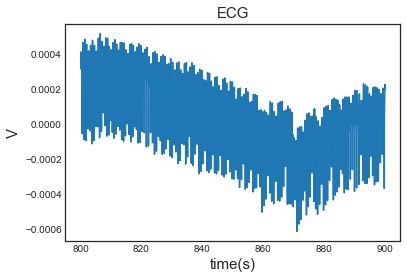

In [340]:

t_ecg = raw_dict['ecg_time']
v_ecg = raw_dict['ecg']

t_mask = (t_ecg>=t_start) & (t_ecg<t_end)

t_ecg = t_ecg[t_mask]
v_ecg = v_ecg[t_mask]
plt.plot(t_ecg, v_ecg)
plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel(unit_dict['ecg'], fontsize=fontsize)
plt.title('ECG', fontsize=fontsize)

In [341]:

t_env = raw_dict['env_time']
pres = raw_dict['pres']
# pres = raw_dict['pres']
temp_skin = raw_dict['temp_skin']
temp_internal = raw_dict['temp_internal']


t_mask = (t_env>=t_start) & (t_env<t_end)

t_env = t_env[t_mask]
pres = pres[t_mask]
temp_skin = temp_skin[t_mask]
temp_internal = temp_internal[t_mask]


Text(0.5, 1.0, 'pres')

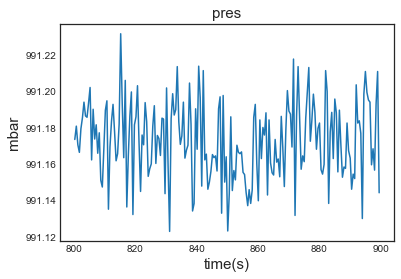

In [342]:

plt.plot(t_env, pres)
plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel(unit_dict['pres'], fontsize=fontsize)
plt.title('pres', fontsize=fontsize)

Text(0.5, 1.0, 'temp skin')

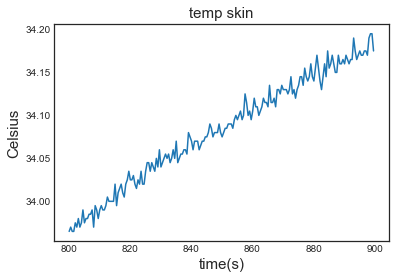

In [343]:
plt.plot(t_env, temp_skin)
plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel(unit_dict['temp'], fontsize=fontsize)
plt.title('temp skin', fontsize=fontsize)

Text(0.5, 1.0, 'temp internal')

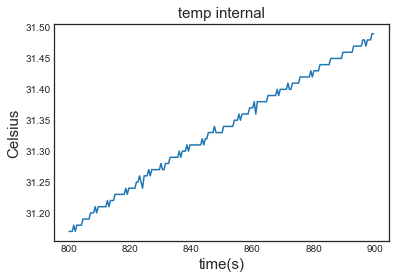

In [344]:

plt.plot(t_env, temp_internal)
plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel(unit_dict['temp'], fontsize=fontsize)
plt.title('temp internal', fontsize=fontsize)

# ACC (raw)

In [345]:
raw_dict['accel_time'].min(), raw_dict['accel_time'].max()

(10.627685546875, 5680.69921875)

Text(0.5, 1.0, 'ACC')

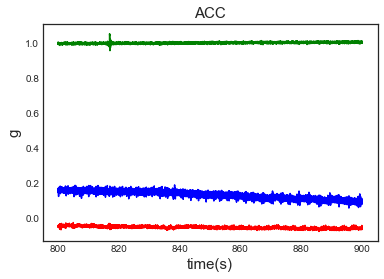

In [346]:

t_acc = raw_dict['accel_time']
v_acc_x= raw_dict['accel_x']
v_acc_y= raw_dict['accel_y']
v_acc_z= raw_dict['accel_z']
t_acc.shape, v_acc_x.shape
# t_mask = (t_acc>50) & (t_acc<90)
t_mask = (t_acc>=t_start) & (t_acc<t_end)
# t_mask = t_acc>=t_start

t_acc = t_acc[t_mask]
v_acc_x = v_acc_x[t_mask]
v_acc_y = v_acc_y[t_mask]
v_acc_z = v_acc_z[t_mask]
plt.plot(t_acc, v_acc_x, 'r')
plt.plot(t_acc, v_acc_y, 'g')
plt.plot(t_acc, v_acc_z, 'b')

plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel('g', fontsize=fontsize)
plt.title('ACC', fontsize=fontsize)

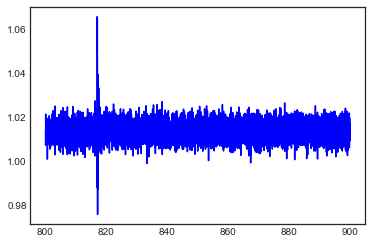

In [347]:
plt.plot(t_acc, (v_acc_x**2 + v_acc_y**2 + v_acc_z**2)**0.5, 'b')


# PPG array 1 (filtered)

In [348]:
raw_dict['ppg_time'].min(), raw_dict['ppg_time'].max()

(10.6357421875, 5680.69677734375)

Text(0.5, 1.0, 'PPG1')

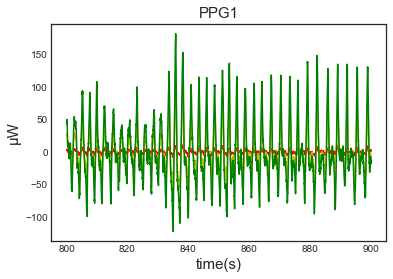

In [349]:

t_ppg = raw_dict['ppg_time']
v_ppg_r_1= raw_dict['ppg_r_1']
v_ppg_ir_1= raw_dict['ppg_ir_1']
v_ppg_g_1= raw_dict['ppg_g_1']

t_mask = (t_ppg>=t_start) & (t_ppg<t_end)

def get_smooth(x, N=10):
    return np.convolve(x, np.ones(N)/N, mode='same')

v_ppg_r_1 = v_ppg_r_1-get_smooth(v_ppg_r_1, N=100)
v_ppg_ir_1 = v_ppg_ir_1-get_smooth(v_ppg_ir_1, N=100)
v_ppg_g_1 = v_ppg_g_1-get_smooth(v_ppg_g_1, N=100)

t_ppg = t_ppg[t_mask]
v_ppg_r_1 = v_ppg_r_1[t_mask]
v_ppg_ir_1 = v_ppg_ir_1[t_mask]
v_ppg_g_1 = v_ppg_g_1[t_mask]
plt.plot(t_ppg, v_ppg_r_1, 'r')
plt.plot(t_ppg, v_ppg_ir_1, 'y')
plt.plot(t_ppg, v_ppg_g_1, 'g')


plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel('μW', fontsize=fontsize)
plt.title('PPG1', fontsize=fontsize)

# PPG array 2 (filtered)

In [350]:

t_ppg = raw_dict['ppg_time']
v_ppg_r_2= raw_dict['ppg_r_2']
v_ppg_ir_2= raw_dict['ppg_ir_2']
v_ppg_g_2= raw_dict['ppg_g_2']

# t_mask = (t_ppg>80) & (t_ppg<90)
# t_mask = (t_ppg>1000) & (t_ppg<1020)

def get_smooth(x, N=10):
    return np.convolve(x, np.ones(N)/N, mode='same')


v_ppg_r_2_DC = get_smooth(v_ppg_r_2, N=100)
v_ppg_ir_2_DC = get_smooth(v_ppg_ir_2, N=100)
v_ppg_g_2_DC = get_smooth(v_ppg_g_2, N=100)

v_ppg_r_2 = v_ppg_r_2-v_ppg_r_2_DC
v_ppg_ir_2 = v_ppg_ir_2-v_ppg_ir_2_DC
v_ppg_g_2 = v_ppg_g_2-v_ppg_g_2_DC

t_ppg = t_ppg[t_mask]
v_ppg_r_2 = v_ppg_r_2[t_mask]
v_ppg_ir_2 = v_ppg_ir_2[t_mask]
v_ppg_g_2 = v_ppg_g_2[t_mask]
v_ppg_r_2_DC = v_ppg_r_2_DC[t_mask]
v_ppg_ir_2_DC = v_ppg_ir_2_DC[t_mask]
v_ppg_g_2_DC = v_ppg_g_2_DC[t_mask]


Text(0.5, 1.0, 'PPG2 AC')

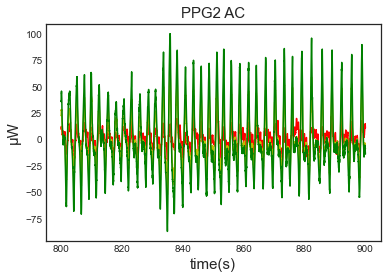

In [351]:



plt.plot(t_ppg, v_ppg_r_2, 'r')
plt.plot(t_ppg, v_ppg_ir_2, 'y')
plt.plot(t_ppg, v_ppg_g_2, 'g')


plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel('μW', fontsize=fontsize)
plt.title('PPG2 AC', fontsize=fontsize)

Text(0.5, 1.0, 'PPG2 DC')

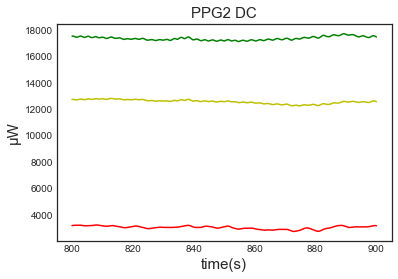

In [352]:



plt.plot(t_ppg, v_ppg_r_2_DC, 'r')
plt.plot(t_ppg, v_ppg_ir_2_DC, 'y')
plt.plot(t_ppg, v_ppg_g_2_DC, 'g')


plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel('μW', fontsize=fontsize)
plt.title('PPG2 DC', fontsize=fontsize)

Text(0.5, 1.0, 'PPG2 PI')

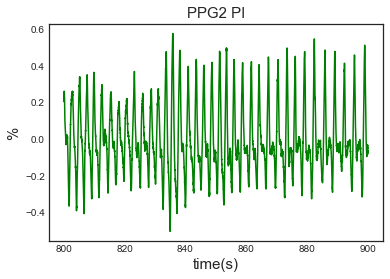

In [354]:

# plt.plot(t_ppg, v_ppg_r_2/v_ppg_r_2_DC*100, 'r')
# plt.plot(t_ppg, v_ppg_ir_2/v_ppg_ir_2_DC*100, 'y')
plt.plot(t_ppg, v_ppg_g_2/v_ppg_g_2_DC*100, 'g')


plt.xlabel('time(s)', fontsize=fontsize)
plt.ylabel('%', fontsize=fontsize)
plt.title('PPG2 PI', fontsize=fontsize)

In [300]:
m = -21.54
b = 106.69

# SpO2 = m * ( v_ppg_r_2/v_ppg_r_2_DC ) / ( v_ppg_ir_2/v_ppg_ir_2_DC ) + b

In [301]:
from scipy.signal import hilbert, chirp

def get_pp(v_ppg):

    analytic_signal = hilbert(v_ppg)
    amplitude_envelope = np.abs(analytic_signal)


    analytic_signal_neg = hilbert(v_ppg*-1)
    amplitude_envelope_neg = np.abs(analytic_signal_neg)*-1


#     plt.plot(v_ppg)
#     plt.plot(amplitude_envelope)
#     plt.plot(amplitude_envelope_neg*-1)


    return amplitude_envelope.mean() - amplitude_envelope_neg.mean()

In [302]:
analytic_signal = hilbert(v_ppg_r_2)
amplitude_envelope = np.abs(analytic_signal)
amplitude_envelope.mean()

analytic_signal = hilbert(v_ppg_r_2*-1)
amplitude_envelope = np.abs(analytic_signal)
amplitude_envelope.mean()

10.69666277576781

In [303]:
SpO2 = m * ( get_pp(v_ppg_r_2)/v_ppg_r_2_DC.mean() ) / ( get_pp(v_ppg_ir_2)/v_ppg_ir_2_DC.mean() ) + b

SpO2

70.25933595870798

In [305]:
# # plt.plot()
# plt.plot(t_ppg, SpO2, 'y')
# plt.ylim(70,200)

# Do interpolation

In [213]:
# from stage1_patch import *


In [214]:
FS_RESAMPLE = 500 # Hz


patch_dict = data_interpolation(raw_dict, FS_RESAMPLE=FS_RESAMPLE)


In [215]:
print(list(patch_dict.keys()))

['ECG', 'accelX', 'accelY', 'accelZ', 'ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2', 'ppg_ir_2', 'time', 'subject_id']


In [216]:
patch_color_dict = {
    'ECG': 'SteelBlue',
    'accelX': 'MangoTando',
    'accelY': 'Olive',
    'accelZ': 'Teal',
    'ppg_g_1': 'ForestGreen',
    'ppg_r_1': 'Maroon',
    'ppg_ir_1': 'burntumber',
    'ppg_g_2': 'Green',
    'ppg_r_2': 'Red',
    'ppg_ir_2': 'Brown',
}

In [217]:
# inspect_patch(patch_dict, title_str='raw', VIS_START=14000, VIS_END=14010, show_plot=True)


# filter the signal

In [218]:
patch_filt_dict = get_filt_dict(patch_dict)


Filtering the raw patch signals...
Signal has been resampled to 500.0 Hz
ECG passband: [1, 30] Hz
SCG passband: [1, 25] Hz
PPG passband: [0.35, 4] Hz


In [219]:
patch_filt_dict

{'time': array([0.000000e+00, 2.000000e-03, 4.000000e-03, ..., 5.669904e+03,
        5.669906e+03, 5.669908e+03]),
 'ECG': array([0.00029141, 0.00027383, 0.00024077, ..., 0.00011905, 0.00013193,
        0.00013865]),
 'ppg_ir_1': array([  -73.20033125,   -73.18309585,   -73.16460916, ...,
        -2324.81977339, -2336.85790679, -2342.856161  ]),
 'ppg_r_1': array([ -31.75295855,  -31.74524733,  -31.7369861 , ..., -102.56702202,
        -103.62940167, -104.13040644]),
 'ppg_g_1': array([-128.37417532, -128.33473768, -128.28861611, ..., -760.59309411,
        -765.55034853, -767.96745274]),
 'ppg_ir_2': array([  -46.38120772,   -46.39501629,   -46.40681163, ...,
        27305.3774392 , 27341.05332716, 27358.91922925]),
 'ppg_r_2': array([  -21.87612968,   -21.88114002,   -21.88447469, ...,
        16890.45322647, 16922.1589652 , 16938.02203074]),
 'ppg_g_2': array([  -78.72434819,   -78.75135069,   -78.7740995 , ...,
        27222.313375  , 27270.10156581, 27293.9630159 ]),
 'accelX': ar

In [220]:

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[sub002]: 29.998000000000047 sec


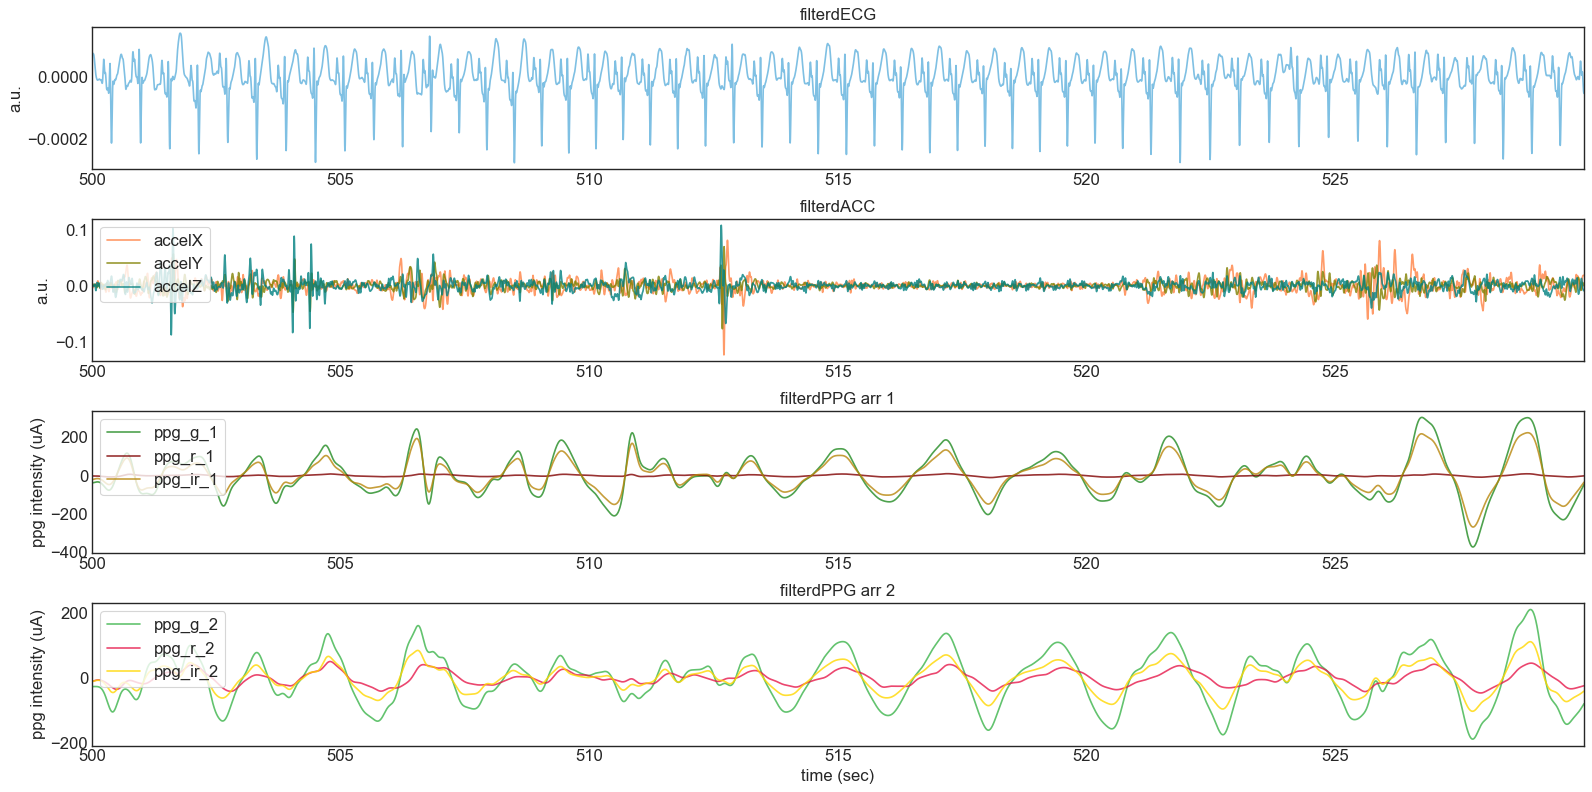

In [224]:
# inspect_patch(patch_filt_dict, title_str='filterd')
inspect_patch(patch_filt_dict, title_str='filterd', VIS_START=500, VIS_END=530, show_plot=True)


In [225]:
def inspect_patch_report(df, title_str, outputdir=None, show_plot=False):
    t_dur = df['time'].values[-1] - df['time'].values[0]

    subject_id = df['subject_id'].values[0]
    print('[{}]: {} sec'.format(subject_id, t_dur))

    t_arr =  df['time'].values
    t_arr = t_arr - t_arr[0]
#     print(t_arr.shape, df['ECG'].values.shape)

    ECG = get_padded_filt(df['ECG'].values, filter_padded=1, lowcutoff=FILT_ECG[0], highcutoff=FILT_ECG[1], Fs=FS_RESAMPLE)
    ppg_g = -get_padded_filt(df['ppg_g_2'].values, filter_padded=1, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)
    ppg_r = -get_padded_filt(df['ppg_r_2'].values, filter_padded=1, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)
    ppg_ir = -get_padded_filt(df['ppg_ir_2'].values, filter_padded=1, lowcutoff=FILT_PPG[0], highcutoff=FILT_PPG[1], Fs=FS_RESAMPLE)
    accelZ = get_padded_filt(df['accelZ'].values, filter_padded=1, lowcutoff=FILT_SCG[0], highcutoff=FILT_SCG[1], Fs=FS_RESAMPLE)

    print(t_arr.shape, ECG.shape)

    # fig = plt.figure(figsize=(3*t_dur/80, 3*10), dpi=50, facecolor='white')
    fig = plt.figure(figsize=(10, 10), dpi=80, facecolor='white')

    fontsize = 20
    scale_factor = 8
    alpha = 1

    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(t_arr, ECG, color=color_dict[sig_color_dict['ECG_filt']], alpha=0.5 ,zorder=1, label='ECG')

    ax1.set_xlim(t_arr[0],t_arr[-1])
#     ax1.set_title('ECG', fontsize=fontsize)
    ax1.set_ylabel('mV', fontsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.legend(loc='upper right', fontsize=fontsize, frameon=True)


    ax2 = fig.add_subplot(3,1,2)
#     ax2.plot(t_arr, data_dict['accelX'], color=color_dict[colornames[list_sigs.index('accelX')]], alpha=alpha ,zorder=1, label='accelX')
#     ax2.plot(t_arr, data_dict['accelY'], color=color_dict[colornames[list_sigs.index('accelY')]], alpha=alpha ,zorder=1, label='accelY')
    ax2.plot(t_arr, accelZ, color=color_dict[sig_color_dict['accelZ_filt']], alpha=alpha ,zorder=1, label='SCG-DV')
    ax2.set_xlim(t_arr[0],t_arr[-1])
#     ax2.set_title('SCG-DV', fontsize=fontsize)
    ax2.set_ylabel('mg', fontsize=fontsize)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.legend(loc='upper right', fontsize=fontsize, frameon=True)

    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(t_arr, ppg_g, color=color_dict[sig_color_dict['ppg_g_2_filt']], alpha=alpha ,zorder=1, label='green PPG')
    ax3.plot(t_arr, ppg_r, color=color_dict[sig_color_dict['ppg_r_2_filt']], alpha=alpha ,zorder=1, label='red PPG')
    ax3.plot(t_arr, ppg_ir, color=color_dict[sig_color_dict['ppg_ir_2_filt']], alpha=alpha ,zorder=1, label='infrared PPG')
    ax3.set_xlim(t_arr[0],t_arr[-1])
#     ax3.set_title('PPG array', fontsize=fontsize)
    ax3.set_ylabel('ppg intensity (uA)', fontsize=fontsize)
    ax3.tick_params(axis='x', labelsize=fontsize)
    ax3.tick_params(axis='y', labelsize=fontsize)
    ax3.legend(loc='upper right', fontsize=fontsize, frameon=True)


    ax3.set_xlabel('time (sec)', fontsize=fontsize)
#     plt.minorticks_on() 

#     ax3.spines['right'].set_visible(False)
#     ax3.spines['top'].set_visible(False)
#     ax3.spines['left'].set_visible(False)
#     ax3.set_tick_params(left = False)

    fig.tight_layout()
    
#     sys.exit()
    
    fig_name = '{}_signl_{}'.format(title_str,subject_id)
    
    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + fig_name+'.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
        
#     if log_wandb:
#         wandb.log({fig_name: wandb.Image(fig)})

[sub002]: 9.99599999999964 sec
(4999,) (4999,)


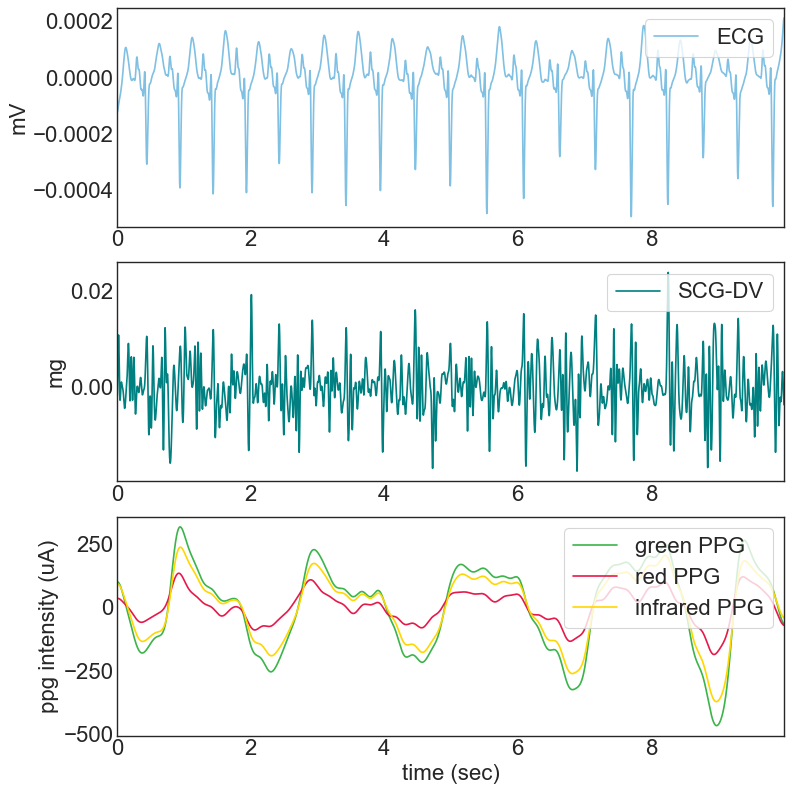

In [233]:
plt_report = True

if plt_report:
#     patch_dict = list_patch_filt[5]
    df = pd.DataFrame.from_dict(patch_dict)
    
    t_start = 2500
    df = df[(df['time'] > t_start) & (df['time'] < t_start+10)]

    inspect_patch_report(df, 'Report', outputdir=outputdir, show_plot=True)